# Importing Necessary Libraries

In [5]:
# OS and Warning files
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings("ignore")

# Analysis Libraries
import pandas as pd
import numpy as np
import xgboost
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import svm, tree, ensemble, neighbors, linear_model
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualization Library
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

%matplotlib inline

In [8]:
# plotly.tools.set_credentials_file(username='neelrast', api_key='tH7Ty1sAOwl8O3JnfLmf')

# Import RL Data

In [9]:
# Loading RL Features Dataset
storm_rl_df = pd.read_csv("../data/storm_rl_norm.csv")
storm_rl_df["cost_category"] = storm_rl_df["cost_category"].astype('category')
storm_rl_df.head()

,storm_names,eff_land_sp,direct,angled,cross,press_mbars,max_sust_winds_kts,storm_surge,storm_tide,moon_phase,low_neap,high_neap,high_ebb,high_tide_line,low_tide_line,norm_cost,cost_category
0,Bob,15.005262,0,1,0,1003,65,0.0,0.0,7,0,1,0,7.5,-0.6,5.963532e+05,moderate
1,Danny,12.080622,1,0,0,987,80,0.0,8.0,27,0,0,0,1.9,-0.4,1.250277e+06,high
2,Elena,19.448238,0,1,0,959,100,10.0,0.0,16,0,1,0,1.4,1.0,3.320953e+07,severe
3,Gloria,31.092933,0,0,0,942,90,0.0,0.0,12,1,0,0,1.3,0.3,0.000000e+00,minimal
4,Gloria,45.238814,0,1,0,961,75,0.0,0.0,12,0,0,0,3.0,0.2,0.000000e+00,minimal


In [10]:
storm_rl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 17 columns):
storm_names           115 non-null object
eff_land_sp           115 non-null float64
direct                115 non-null int64
angled                115 non-null int64
cross                 115 non-null int64
press_mbars           115 non-null int64
max_sust_winds_kts    115 non-null int64
storm_surge           115 non-null float64
storm_tide            115 non-null float64
moon_phase            115 non-null int64
low_neap              115 non-null int64
high_neap             115 non-null int64
high_ebb              115 non-null int64
high_tide_line        115 non-null float64
low_tide_line         115 non-null float64
norm_cost             115 non-null float64
cost_category         115 non-null category
dtypes: category(1), float64(6), int64(9), object(1)
memory usage: 14.8+ KB


In [11]:
storm_rl_df["moon_phase"] = abs(abs(storm_rl_df.moon_phase - 14)-7)

In [12]:
storm_rl_df["cost_category"].unique()

[moderate, high, severe, minimal, low, catastrophic]
Categories (6, object): [moderate, high, severe, minimal, low, catastrophic]

In [13]:
cateogry_types = ['low', 'minimal', 'moderate', 'high', 'severe',  'catastrophic']

storm_rl_df["cost_category_num"] = storm_rl_df.cost_category.astype("category", categories=cateogry_types).cat.codes

In [14]:
#Loading winds and rain data
winds_rain = pd.read_csv("../data/wind_rain.csv")
winds_rain = winds_rain.drop(columns={"Rain Rate"})
winds_rain.head()

,storm_names,year,month,day,Max Radii,Point Maxima
0,Bob,1985,7,25,NaN,21.50
1,Danny,1985,8,15,NaN,9.80
2,Elena,1985,9,2,NaN,15.67
3,Gloria,1985,9,27,NaN,9.70
4,Gloria,1985,9,27,NaN,9.70


In [15]:
winds_rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 6 columns):
storm_names     115 non-null object
year            115 non-null int64
month           115 non-null int64
day             115 non-null int64
Max Radii       104 non-null float64
Point Maxima    115 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 5.5+ KB


In [16]:
winds_rain = winds_rain.fillna(0)

In [17]:
storm_rl_df["year"] = winds_rain.year
storm_rl_df["month"] = winds_rain.month
storm_rl_df["day"] = winds_rain.day
storm_rl_df["Max Radii"] = winds_rain["Max Radii"]
storm_rl_df["Point Maxima"] = winds_rain["Point Maxima"]

In [18]:
storm_rl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 23 columns):
storm_names           115 non-null object
eff_land_sp           115 non-null float64
direct                115 non-null int64
angled                115 non-null int64
cross                 115 non-null int64
press_mbars           115 non-null int64
max_sust_winds_kts    115 non-null int64
storm_surge           115 non-null float64
storm_tide            115 non-null float64
moon_phase            115 non-null int64
low_neap              115 non-null int64
high_neap             115 non-null int64
high_ebb              115 non-null int64
high_tide_line        115 non-null float64
low_tide_line         115 non-null float64
norm_cost             115 non-null float64
cost_category         115 non-null category
cost_category_num     115 non-null int8
year                  115 non-null int64
month                 115 non-null int64
day                   115 non-null int64
Max Radii          

## Data Exploration

In [19]:
storm_rl_df.groupby(storm_rl_df["cost_category"]).count()

,storm_names,eff_land_sp,direct,angled,cross,press_mbars,max_sust_winds_kts,storm_surge,storm_tide,moon_phase,...,high_ebb,high_tide_line,low_tide_line,norm_cost,cost_category_num,year,month,day,Max Radii,Point Maxima
cost_category,,,,,,,,,,,,,,,,,,,,,
catastrophic,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
high,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
low,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
minimal,48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
moderate,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
severe,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17


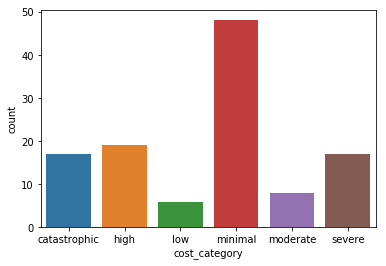

In [20]:
ax = sns.countplot(storm_rl_df["cost_category"],label="Count")

In [21]:
storm_rl_df['year'].value_counts()

2004    10
1998     8
2005     8
1985     7
2002     7
2008     6
1995     6
2017     6
1999     5
1996     4
2006     4
2012     4
2003     4
2001     3
2011     3
1989     3
1992     3
1994     3
1986     2
1991     2
2015     2
1997     2
2000     2
2016     2
2007     2
2010     1
2014     1
1993     1
2013     1
1988     1
1987     1
2009     1
Name: year, dtype: int64

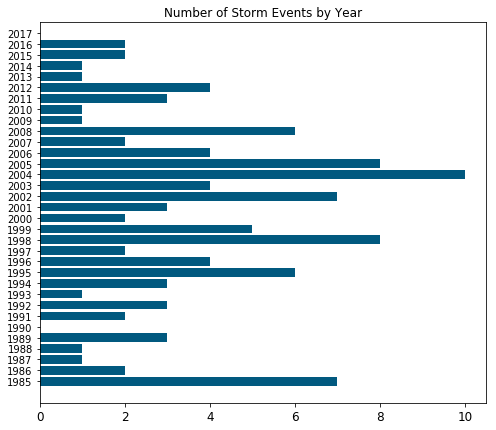

In [22]:
plt.figure(figsize=(8,7))
plt.barh(storm_rl_df['year'].value_counts().sort_index().index[:-1], 
         storm_rl_df['year'].value_counts().sort_index().values[:-1], color = '#01597f')
plt.title('Number of Storm Events by Year', fontsize = 12)
plt.yticks(np.arange(1985,2018,1), fontsize = 10)
plt.xticks(fontsize = 12);

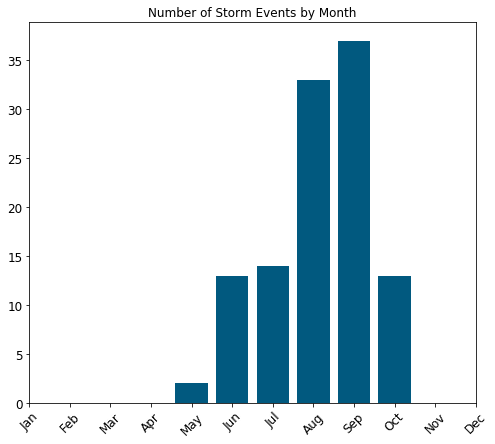

In [23]:
plt.figure(figsize=(8,7))
plt.bar(storm_rl_df['month'].value_counts().sort_index().index[:-1], 
         storm_rl_df['month'].value_counts().sort_index().values[:-1], color = '#01597f')
plt.title('Number of Storm Events by Month', fontsize = 12)
plt.xticks(range(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
           rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12);

In [24]:
coordinates = pd.read_csv("../data/storm_main.csv")

In [25]:
coordinates = coordinates.drop(columns={'time', 'zone', 'max_winds_kts', 'SS', 'pre_lat', 'pre_long', 'sub_lat',
       'sub_long', 'dir', 'sp1', 'sp2', 'frame', 'hours', 'eff_wind_sp',
       'angle_binary', 'direct', 'angled', 'cross', 'press_mbars',
       'max_sust_winds_kts', 'width_storm', 'storm_surge', 'storm_tide',
       'moon_phase', 'tide_phase', 'low_neap', 'high_neap', 'high_ebb',
       'high_tide_line', 'low_tide_line', 'rate_rainfall', 'total_rainfall',
       'deaths', 'states_affected', 'damage_unadj', 'col_index',
       'infaltion_adj'})
coordinates["norm_cost"] = storm_rl_df["norm_cost"]
coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 7 columns):
storm_names    115 non-null object
year           115 non-null int64
month          115 non-null int64
day            115 non-null int64
lat_n          115 non-null float64
long_w         115 non-null float64
norm_cost      115 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 6.4+ KB


In [26]:
coordinates['text'] = 'Hurricane ' + coordinates['storm_names'] + '<br>Occured on ' + coordinates['month'].astype('str') + '/' + coordinates['day'].astype('str') + '/' + coordinates['year'].astype('str') + ' <br>Norm. Damage '  +  coordinates['norm_cost'].map('${:,}'.format).astype('str')

scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]

data = [go.Scattergeo(
        locationmode = 'USA-states',
        lon = -1*coordinates['long_w'],
        lat = coordinates['lat_n'],
        text = coordinates['text'],
        mode = 'markers',
        marker = dict( 
            size = 8, 
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = coordinates['norm_cost'],
            cmax = coordinates['norm_cost'].max(),
            colorbar=dict(
                title="Normalized Damage caused by Storm Events <br> since 1985 till 2018"
            )
        ))]

layout = dict(
        title = 'Coordinates of Storm Events which caused land slides at point of impact.', 
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5        
        ),
    )

fig = go.Figure(data=data, layout=layout )
py.iplot(fig, filename='storm-events')

In [27]:
# X_rl -> features
# y_rl -> labels

X_rl = storm_rl_df.drop(columns={"storm_names","year","month","day","norm_cost","cost_category","cost_category_num"})
y_rl = storm_rl_df["cost_category_num"]
classes = pd.merge(y_rl, storm_rl_df["cost_category"], left_index=True,  right_index =True)